# Packages loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import warnings
from scipy import interpolate as interp
from astropy import coordinates
from astropy.coordinates import Galactic
import astropy.units as u
import mass_photometry_tools as massPhoto
from astropy.coordinates import LSR
from astropy.coordinates import SkyCoord
import pickle
import DBSCANoutputAnalysisTools as dbat
from scipy.optimize import curve_fit

sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# General data loading

In [2]:
# Photometric and kinematic errors data from GDR3
allErrorsOriginal = pd.read_csv('builded_or_modified_cat/gdr3MSPMS.csv',usecols=['phot_g_mean_mag',
                                                                                 'parallax',
                                                                                 'MG_err',
                                                                                 'BP_err',
                                                                                 'RP_err',
                                                                                 'G_err',
                                                                                 'parallax_error',
                                                                                 'radial_velocity_error',
                                                                                 'pmra_error',
                                                                                 'pmdec_error'])

# NYMGs general statistics
finalStatsForNymgs   = pd.read_csv('statsForSyntheticNymgs.csv')    

# MS and PMS data from GDR3
MSPMS                = pd.read_csv('builded_or_modified_cat/gdr3RVMSPMS.csv')

# all known NYMGs GDR3 data
nymgsMatchGdr3       = pd.read_csv('nymgs_gdr3_match.csv')

# Errors interpolation

In [3]:
allErrorsOriginal['MG'] = allErrorsOriginal.phot_g_mean_mag+5-5*np.log10(1000/allErrorsOriginal.parallax)
allErrorsOriginal['BR_err'] = np.sqrt(allErrorsOriginal.BP_err**2+allErrorsOriginal.RP_err**2)
Gmin = allErrorsOriginal.MG.min()
Gmax = allErrorsOriginal.MG.max()
N = 20
MGbins = np.arange(Gmin,Gmax,(Gmax-Gmin)/N)

MGtoErrToInterpolate = pd.DataFrame()
nSigmaMG = 50
nSigmaBR = 10

for i in np.arange(0,len(MGbins)-1,1):
    binMin  = MGbins[i]
    binMax  = MGbins[i+1]
    allErrorsOriginalBin = allErrorsOriginal[(allErrorsOriginal.MG >= binMin) & (allErrorsOriginal.MG < binMax)]
    allErrorsOriginalBin = pd.DataFrame({'MG':[(binMin+binMax)/2],
                                         'MG_err':[allErrorsOriginalBin.MG_err.median()+nSigmaMG*allErrorsOriginalBin.MG_err.std()],
                                         'BR_err':[np.sqrt((allErrorsOriginalBin.BP_err.median()+nSigmaBR*allErrorsOriginalBin.BP_err.std())**2+\
                                                           (allErrorsOriginalBin.RP_err.median()+nSigmaBR*allErrorsOriginalBin.RP_err.std())**2)]})
    MGtoErrToInterpolate = pd.concat([MGtoErrToInterpolate,allErrorsOriginalBin],axis=0).reset_index(drop=True)

MGtoMGerr = interp.interp1d(MGtoErrToInterpolate.MG,MGtoErrToInterpolate.MG_err)
MGtoBRerr = interp.interp1d(MGtoErrToInterpolate.MG,MGtoErrToInterpolate.BR_err)

# Sample and ages definition

In [4]:
sample            = 'RVs'
nymgAges          = finalStatsForNymgs.age
isochroneAges     = pd.DataFrame({'age':np.arange(1e7,11e7,1e7)})
isochroneNymgAges = pd.DataFrame(columns=isochroneAges.columns)
for i in np.arange(0,len(nymgAges),1):
    age = isochroneAges[np.abs(isochroneAges.age-finalStatsForNymgs.age.iloc[i]*1e6) == np.min(np.abs(isochroneAges.age-finalStatsForNymgs.age.iloc[i]*1e6))].iloc[0][0]
    isochroneNymgAges = pd.concat([isochroneNymgAges,pd.DataFrame({'age':[age]})],axis=0)

# Synthetic data results analysis

In [5]:
kinematicColumns     = ['X','Y','Z','U','V','W']
dBoxes               = [20,20,20,10,10,10]
n                    = 1000

allSyntheticResults  = {}
allsyntheticnBestCases        = {}
for i in np.arange(0,finalStatsForNymgs.shape[0],1):
    nymgName         = finalStatsForNymgs.NYMG.iloc[i]
    syntheticResultsDict = pd.read_pickle(f'dataframes_output/Ndmethod/synth_groups_and_field/synthGroupsAndFieldPurityCompletness_{sample}_{nymgName}.pickle')
    syntheticResults = pd.DataFrame()
    for j in np.arange(0,len(syntheticResultsDict[nymgName]),1):
        syntheticResults = pd.concat([syntheticResults,syntheticResultsDict[nymgName][j]],axis=0).reset_index(drop=True)
    
    clusterDensity = syntheticResults.nObservedCluster
    for k in np.arange(0,len(kinematicColumns),1):
        columns = [kinematicColumns[k]+'BoxMin',kinematicColumns[k]+'Mean',kinematicColumns[k]+'BoxMax']
        stdk    = pd.DataFrame({'min':syntheticResults[columns[0]]+dBoxes[k],
                                'mean':syntheticResults[columns[1]],
                                'max':syntheticResults[columns[2]]-dBoxes[k]}).std(axis=1, numeric_only=True)
        clusterDensity = clusterDensity/stdk
    syntheticResults['clusterDensity'] = clusterDensity
    
    syntheticnBestCases = syntheticResults[syntheticResults.min_purity_recovery < 1]
    syntheticnBestCases = syntheticnBestCases.sort_values('min_purity_recovery')
    syntheticnBestCases = syntheticnBestCases.tail(n).reset_index(drop=True)
    syntheticnBestCases = syntheticnBestCases.sort_values('density')
    syntheticnBestCases = syntheticnBestCases.head(int(0.1*n)).reset_index(drop=True)
    
    allsyntheticnBestCases.update({nymgName:syntheticnBestCases})
    allSyntheticResults.update({nymgName:syntheticResults})

# Real data output analysis

In [6]:
maxMG                = 0.5
allAnalysisResults   = {}
allnvrFinalCoords    = {}
allNymgDensities     = {}

rexp = 3
vexp = 1
if sample == '5D':
    vexp = 2
    sample_class = '5d'
elif sample == 'RVs':
    vexp = 3
    sample_class = '6d'
        
for i in np.arange(0,finalStatsForNymgs.shape[0],1):
    AGE                = isochroneNymgAges.age.iloc[i]
    nymgName           = finalStatsForNymgs.NYMG.iloc[i]
    detectedClusters   = pd.read_pickle(f'dataframes_output/Ndmethod/realData_{sample}_{AGE}.pickle')
    nvrFinalCoords     = pd.read_csv(f'dataframes_output/Ndmethod/nvrClusterFinalCoord_{sample}_{AGE}.csv')

    MSPMSRVage         = massPhoto.isochroneSelector(data           = MSPMS,
                                                     age            = AGE,
                                                     deltaMag       =  [1e6,0.5],
                                                     dataMagName    = 'MG',
                                                     dataColorNames = ['phot_bp_mean_mag','phot_rp_mean_mag'])

    nymg                = nymgsMatchGdr3[nymgsMatchGdr3.YNMG == nymgName]
    nymgsMatchGdr3      = nymgsMatchGdr3.set_index(nymgsMatchGdr3.source_id)
    MSPMSRVage          = MSPMSRVage.set_index(MSPMSRVage.source_id)
    nymg                = nymg.set_index(nymg.source_id)
    observedNymg        = pd.concat([nymg.YNMG,MSPMSRVage],axis=1,join='inner')
    analysisResults     = dbat.setOfClustersToAnalysisResults(detectedClusters,
                                                              observedNymg,
                                                              nymg,
                                                              finalStatsForNymgs.NYMG.iloc[i],
                                                              nvrFinalCoords)
    analysisResults    = pd.concat([analysisResults,
                                    pd.DataFrame({'density':analysisResults.Nmin/(analysisResults.reps**rexp*analysisResults.veps**vexp),
                                                  'min_purity_recovery':analysisResults[['observedRecovery','groupsPurity']].min(axis=1),
                                                  'max_purity_recovery':analysisResults[['observedRecovery','groupsPurity']].max(axis=1)},
                                                index=analysisResults.index)],axis=1)

    nymgDensity = observedNymg.shape[0]/finalStatsForNymgs[finalStatsForNymgs.NYMG == nymgName].stdU
    for col in ['stdV','stdW','stdX','stdY','stdZ']:
        nymgDensity = nymgDensity/finalStatsForNymgs[finalStatsForNymgs.NYMG == nymgName][col]

    allNymgDensities.update({nymgName: nymgDensity.iloc[0]})
    allAnalysisResults.update({nymgName: analysisResults})
    allnvrFinalCoords.update({nymgName: nvrFinalCoords})

# Search for best cases

In [7]:
similarity_tolerance = 0.1
allBestCases         = {}
allnBestCases        = {}

for i in np.arange(0,finalStatsForNymgs.shape[0],1):
    nymgName            = finalStatsForNymgs.NYMG.iloc[i]
    AGE                 = isochroneNymgAges.age.iloc[i]
    syntheticnBestCases = allsyntheticnBestCases[nymgName]
    detectedClusters    = pd.read_pickle(f'dataframes_output/Ndmethod/realData_{sample}_{AGE}.pickle')
    
    analysisResults     = allAnalysisResults[nymgName].drop(['density','min_purity_recovery','max_purity_recovery'],axis=1)

    bestCase            = dbat.bestCaseFinder(analysisResults,
                                              similarity_tolerance,
                                              'recovery',
                                              sample_class)
    
    
    
    
    
    MSPMSRVage         = massPhoto.isochroneSelector(data           = MSPMS,
                                                     age            = AGE,
                                                     deltaMag       = [1e6,0.5],
                                                     dataMagName    = 'MG',
                                                     dataColorNames = ['phot_bp_mean_mag','phot_rp_mean_mag'])
    nymg                = nymgsMatchGdr3[nymgsMatchGdr3.YNMG == nymgName]
    
    MSPMSRVage          = MSPMSRVage.set_index(MSPMSRVage.source_id)
    nymg                = nymg.set_index(nymg.source_id)
    
    observedNymg        = pd.concat([nymg.YNMG,MSPMSRVage],axis=1,join='inner')
    
    nBestCases          = {}
    for j in np.arange(0,syntheticnBestCases.shape[0],1):
        syntheticCase = syntheticnBestCases.iloc[j]
        Nmin          = syntheticCase.Nmin
        veps          = syntheticCase.veps
        reps          = syntheticCase.reps
        realCase      = detectedClusters[Nmin][veps][reps]
        realCase      = realCase.set_index(realCase.input_index)
        realCase      = pd.concat([observedNymg,realCase.cluster_labels],axis=1,join='inner')
        nBestCases.update({(Nmin,veps,reps):realCase})
        
    allnBestCases.update({nymgName:nBestCases})
    allBestCases.update({nymgName:bestCase})

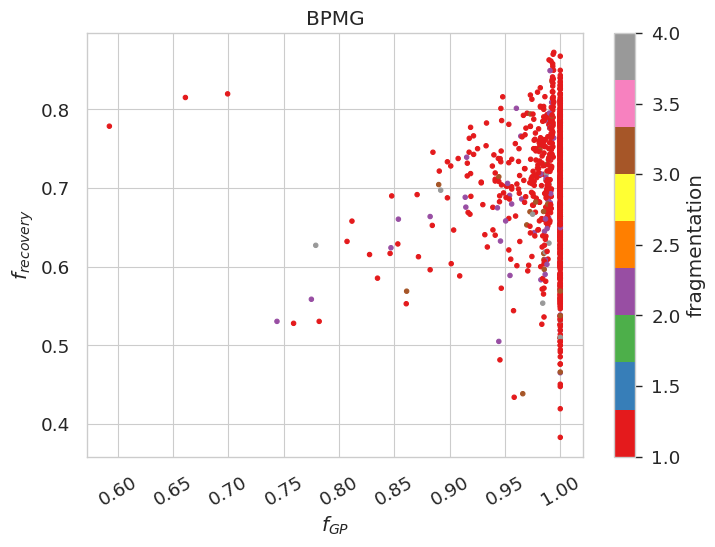

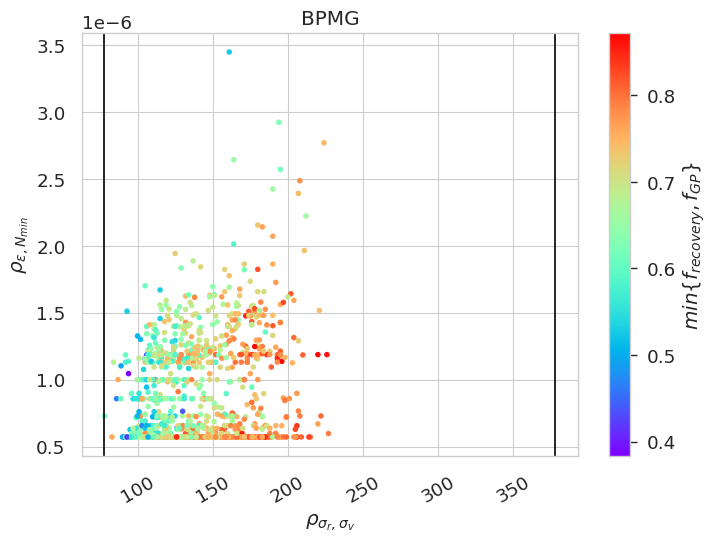

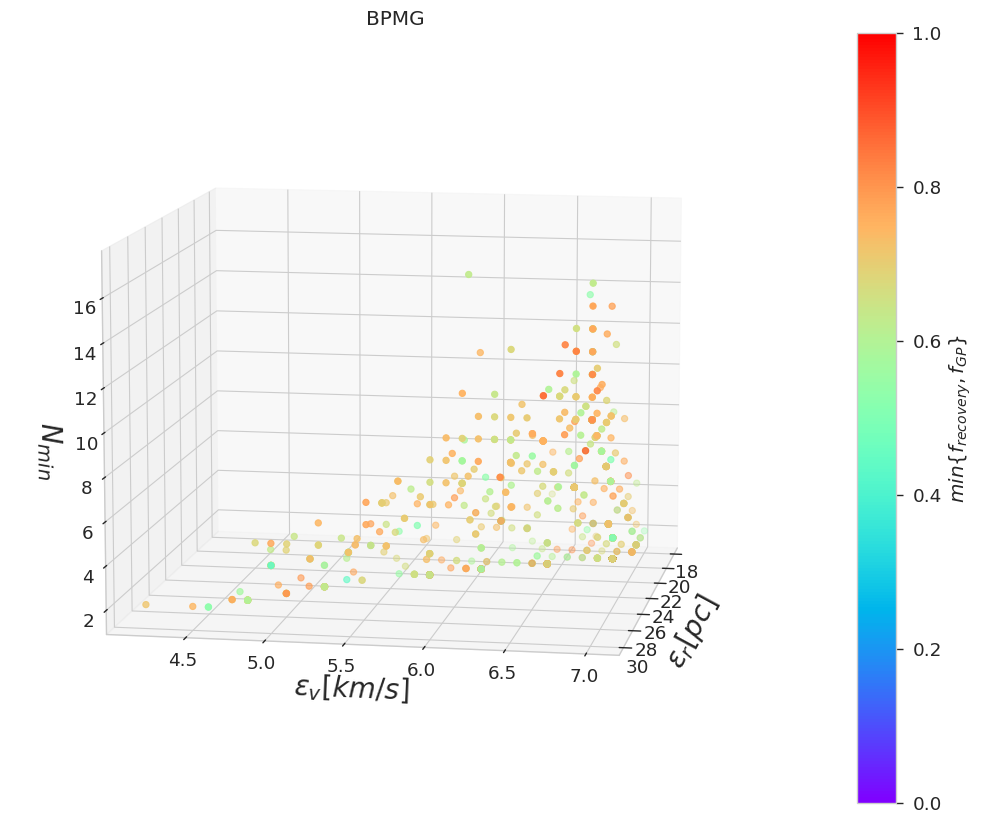

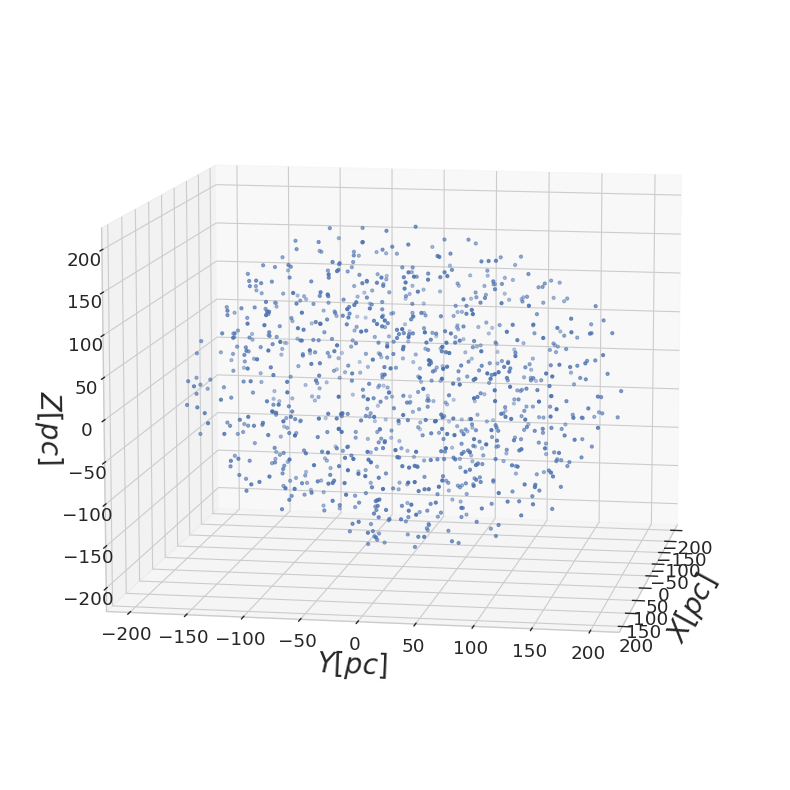

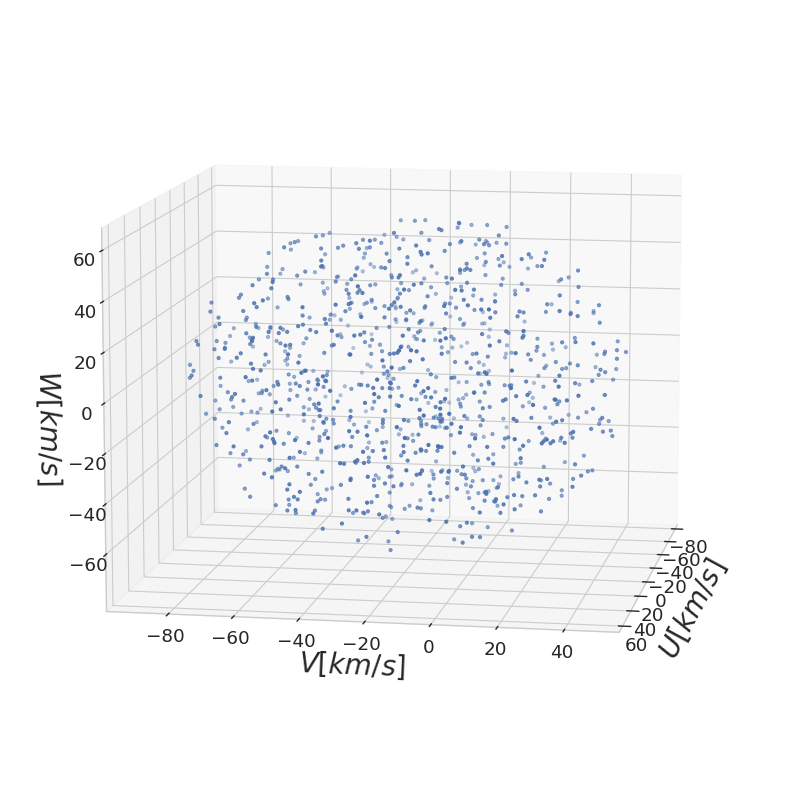

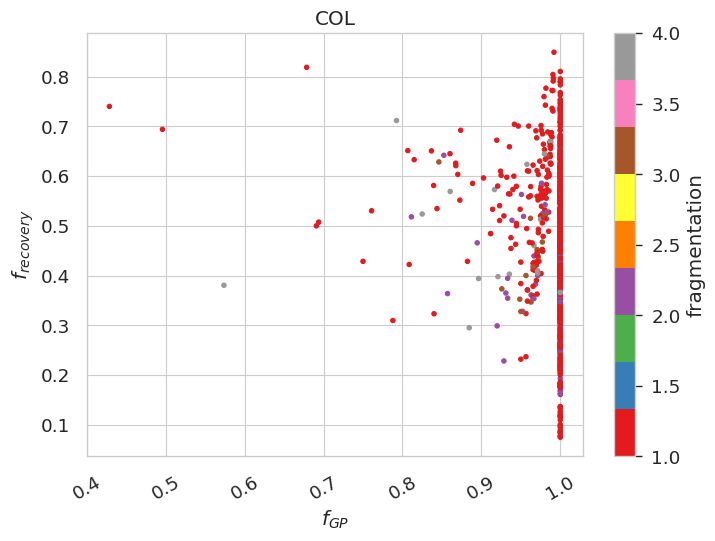

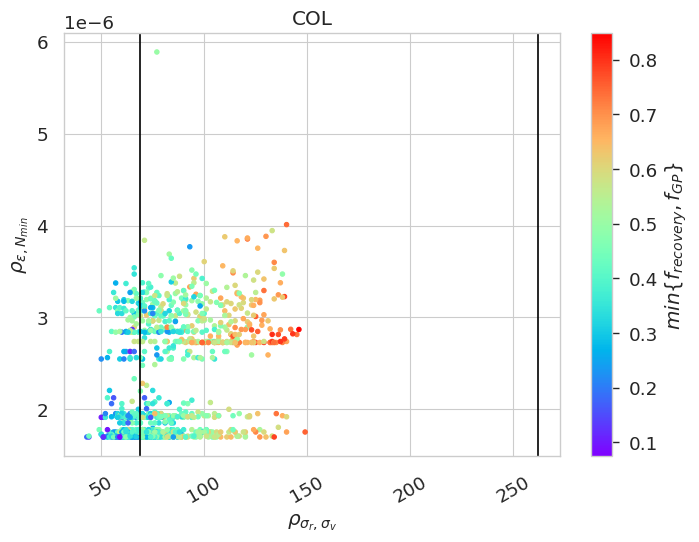

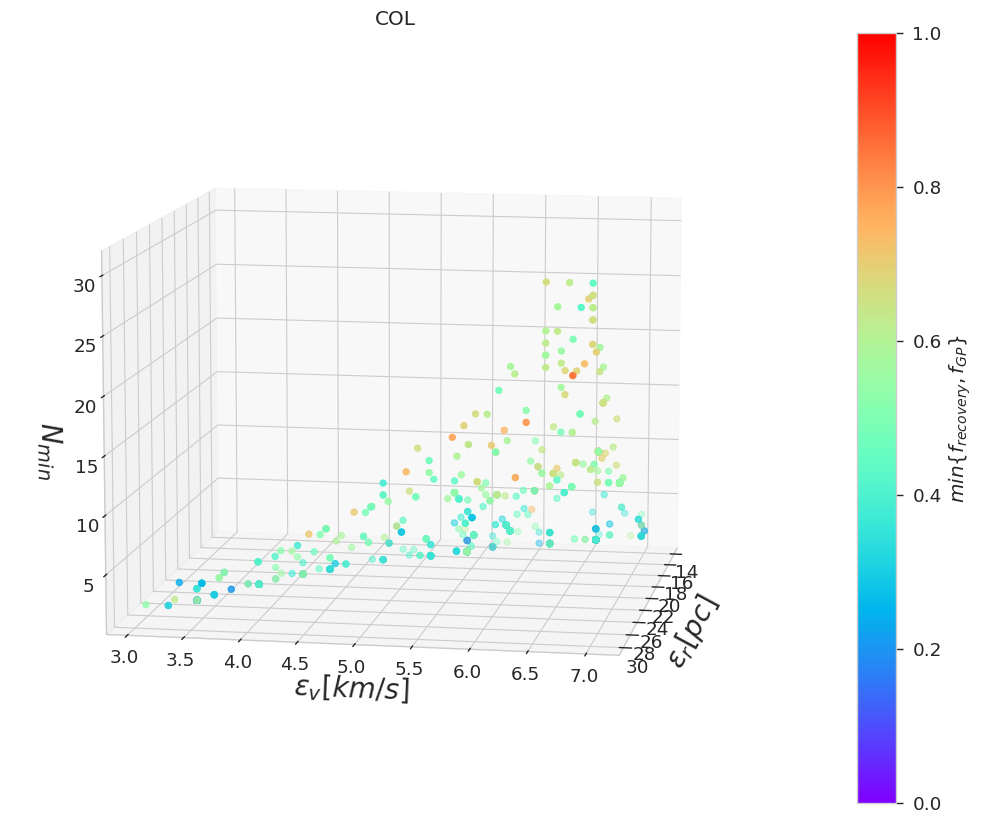

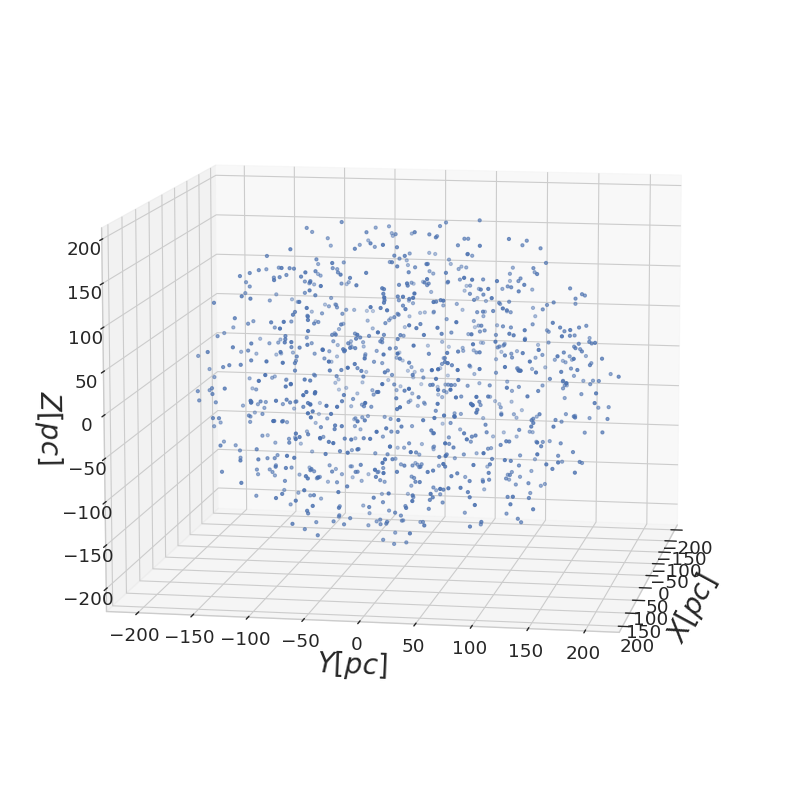

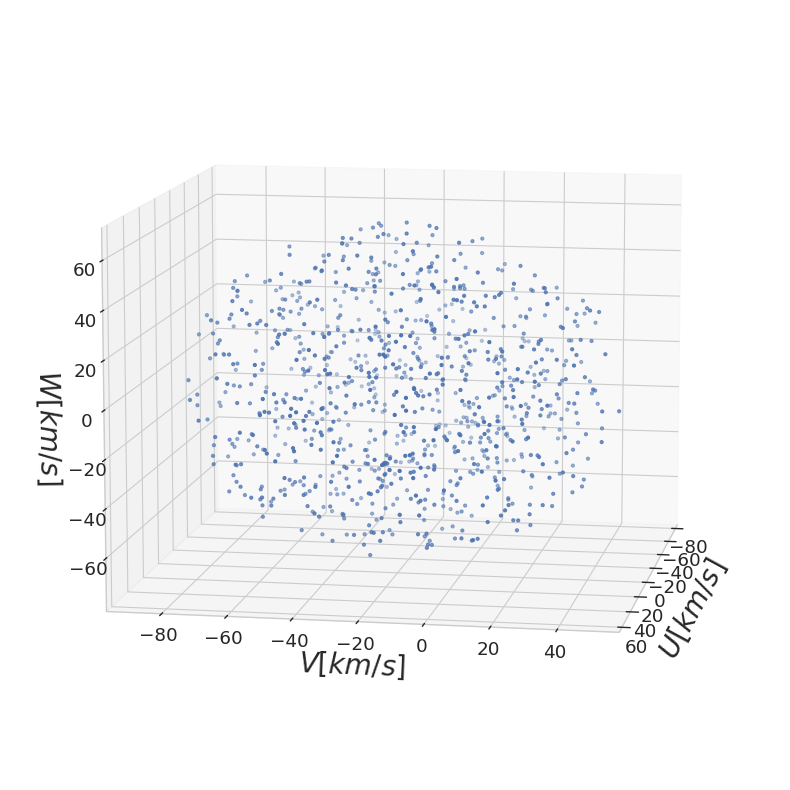

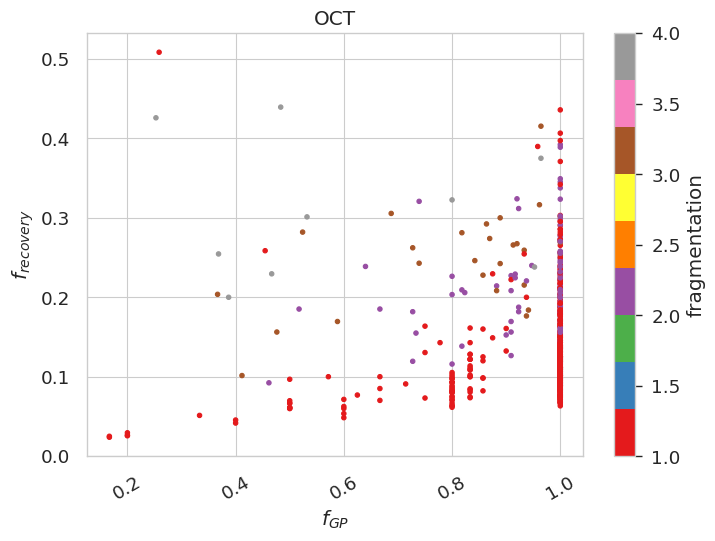

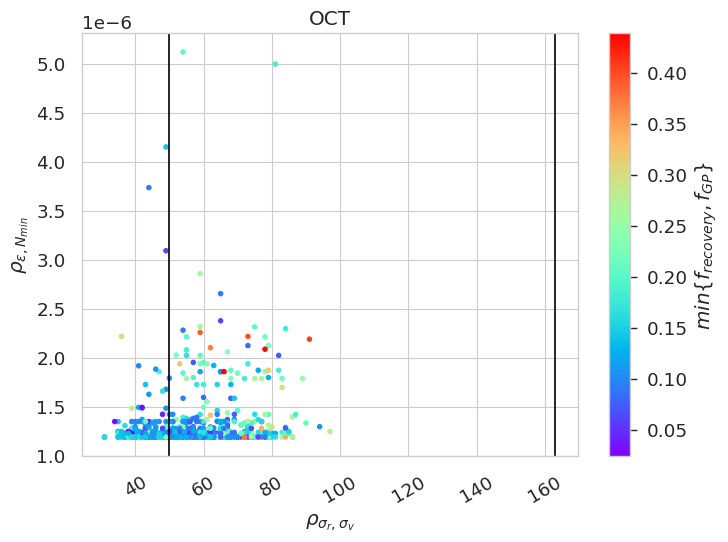

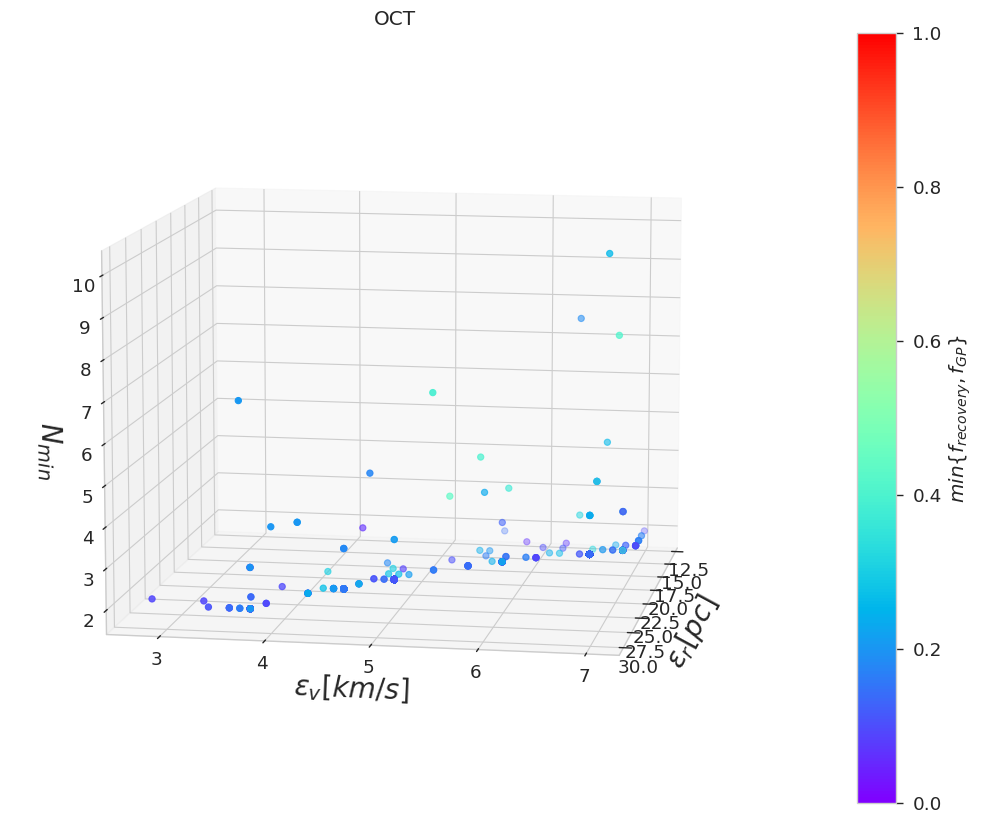

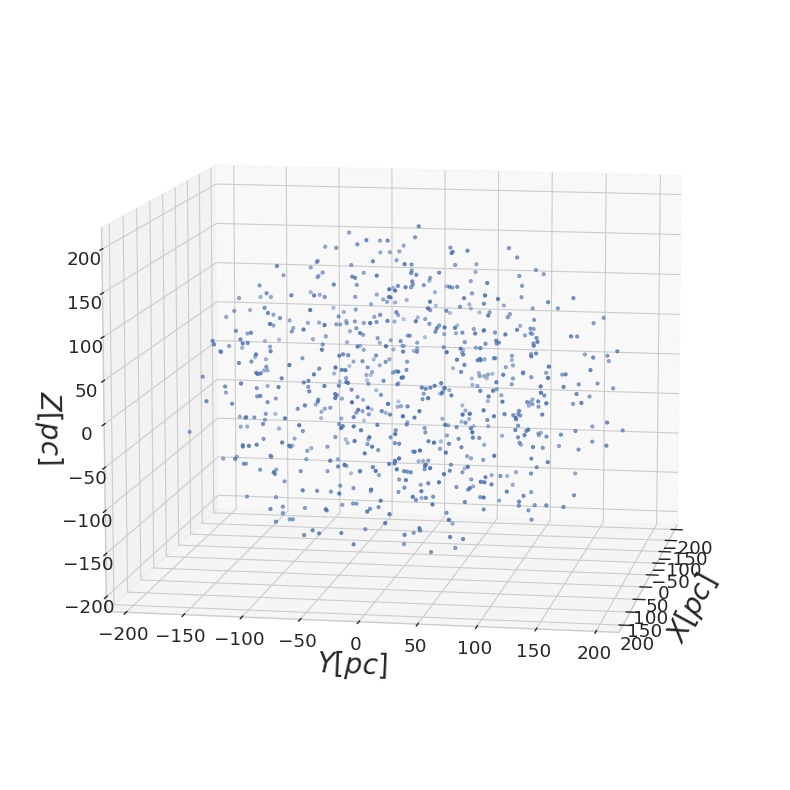

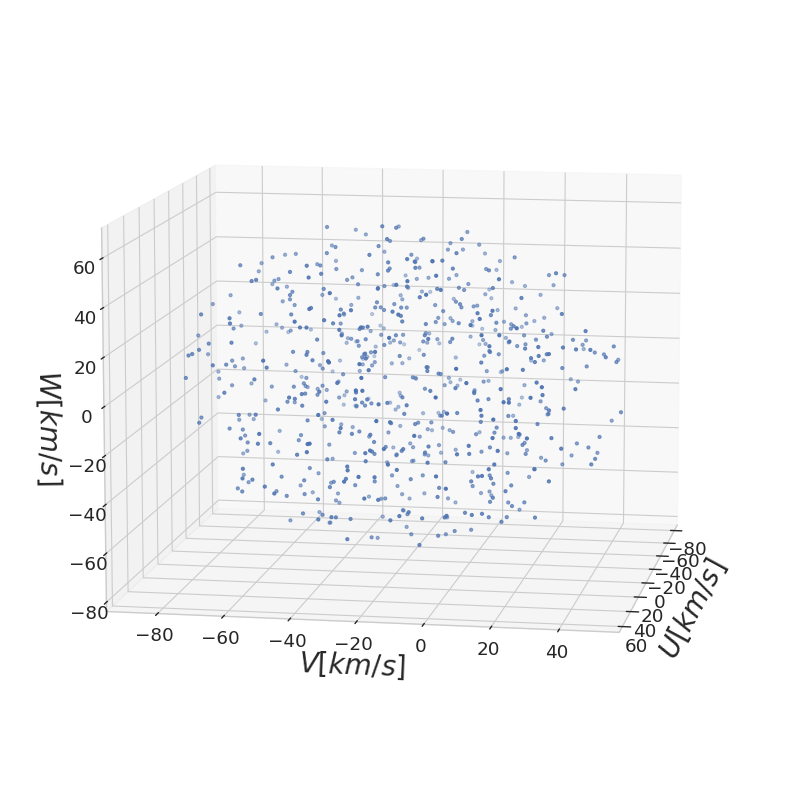

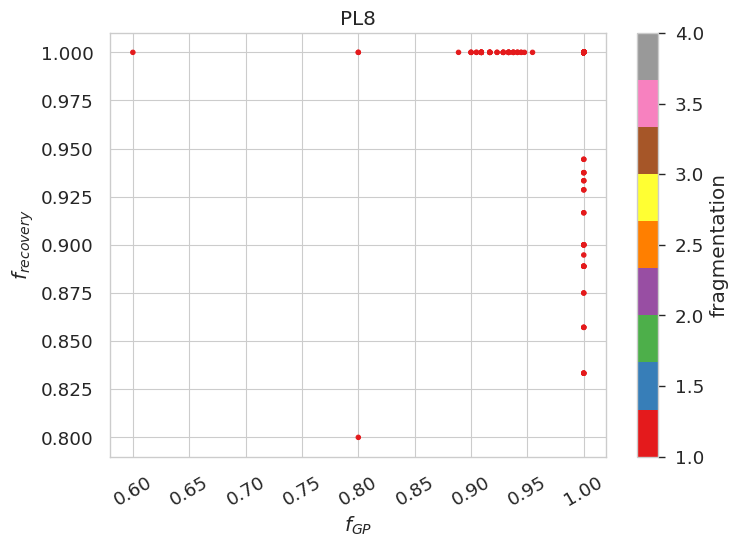

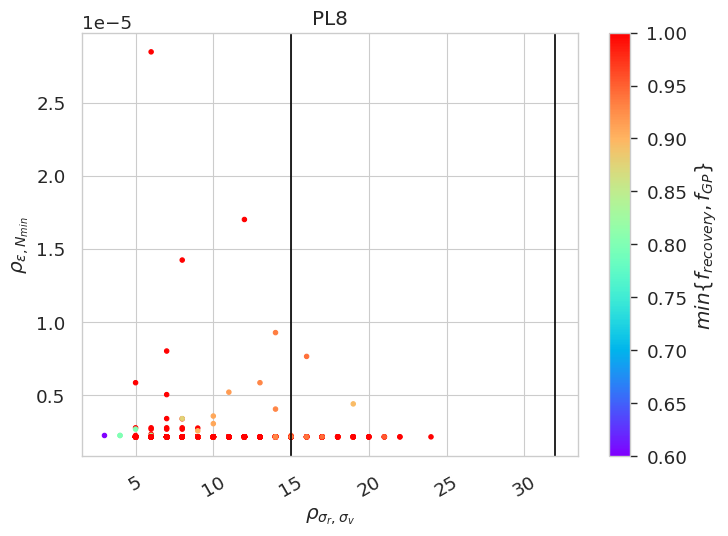

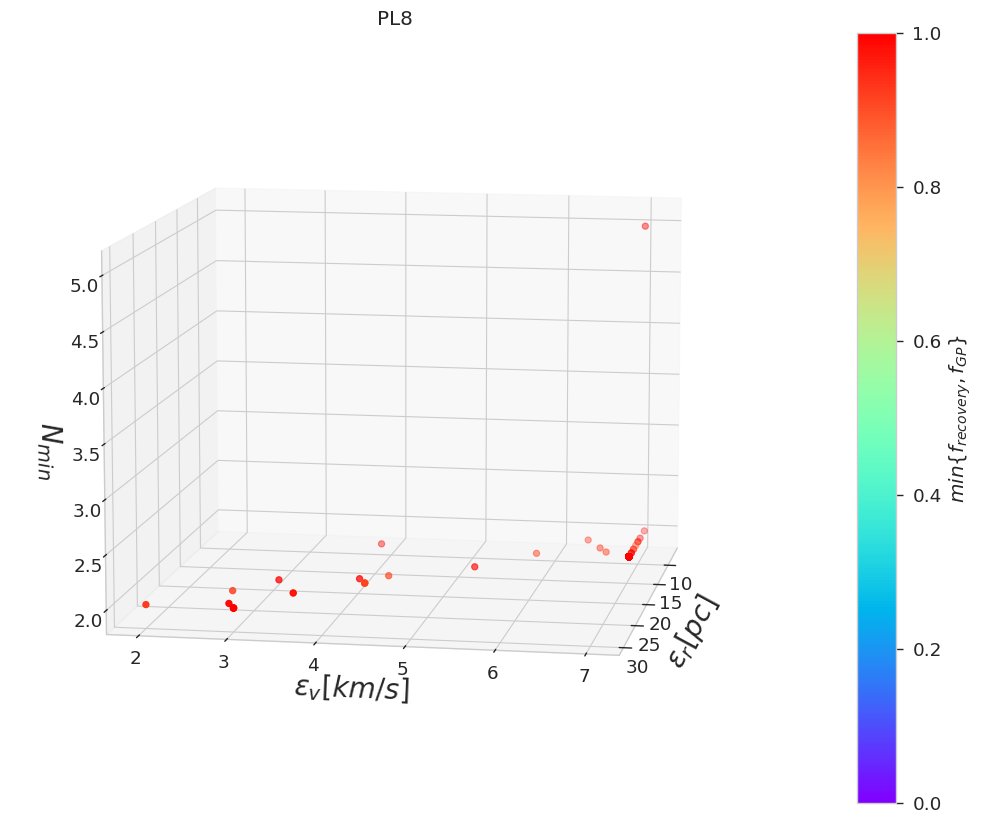

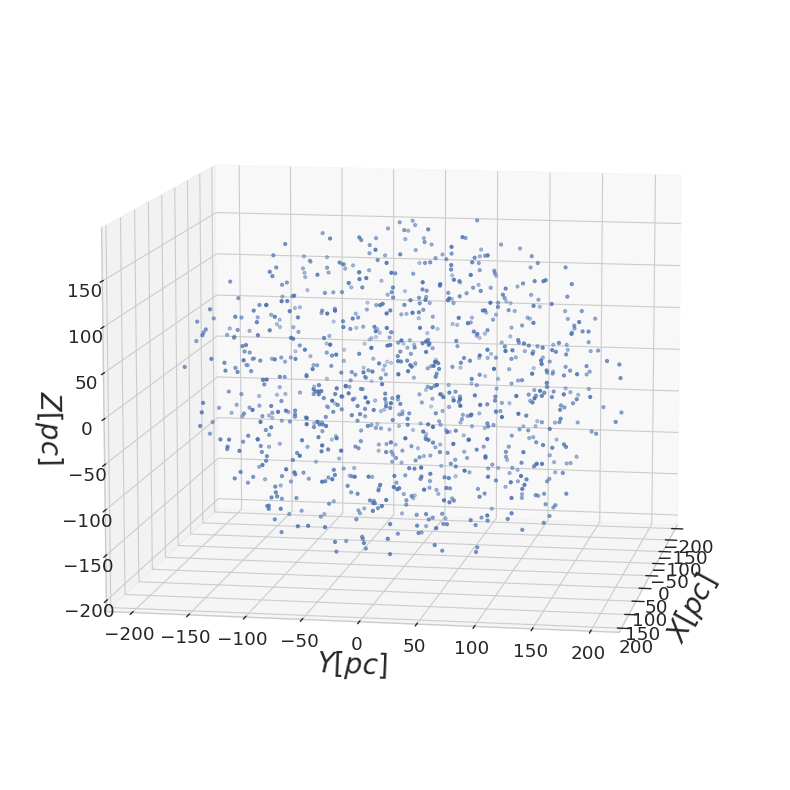

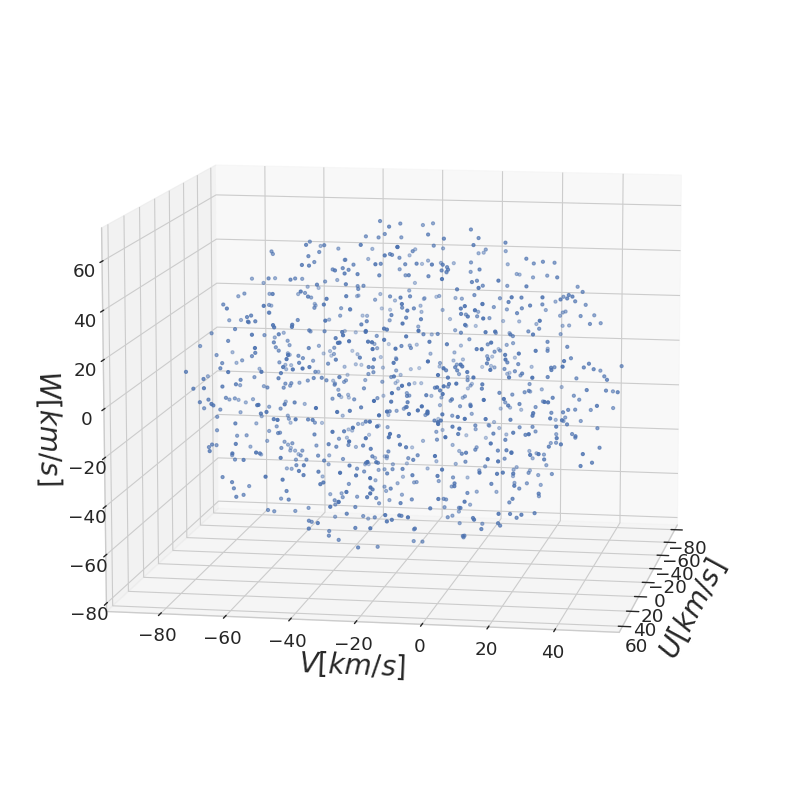

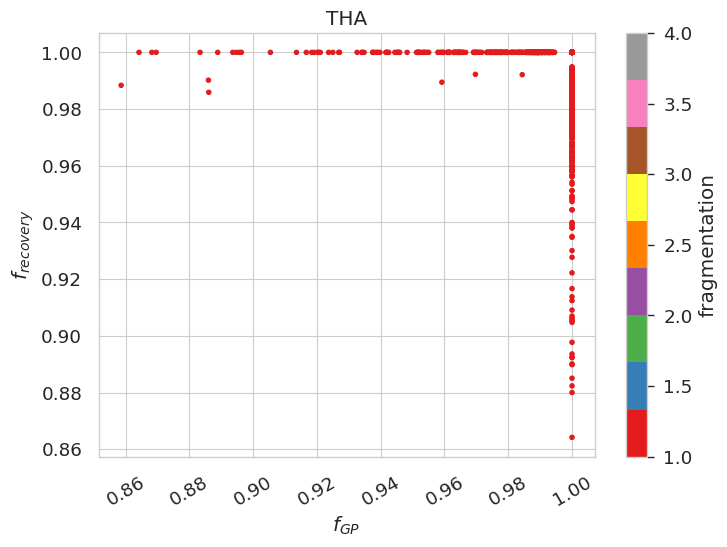

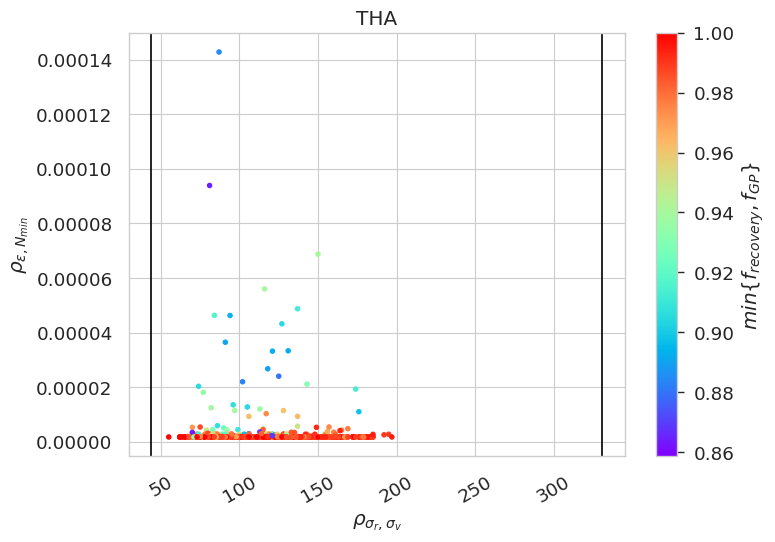

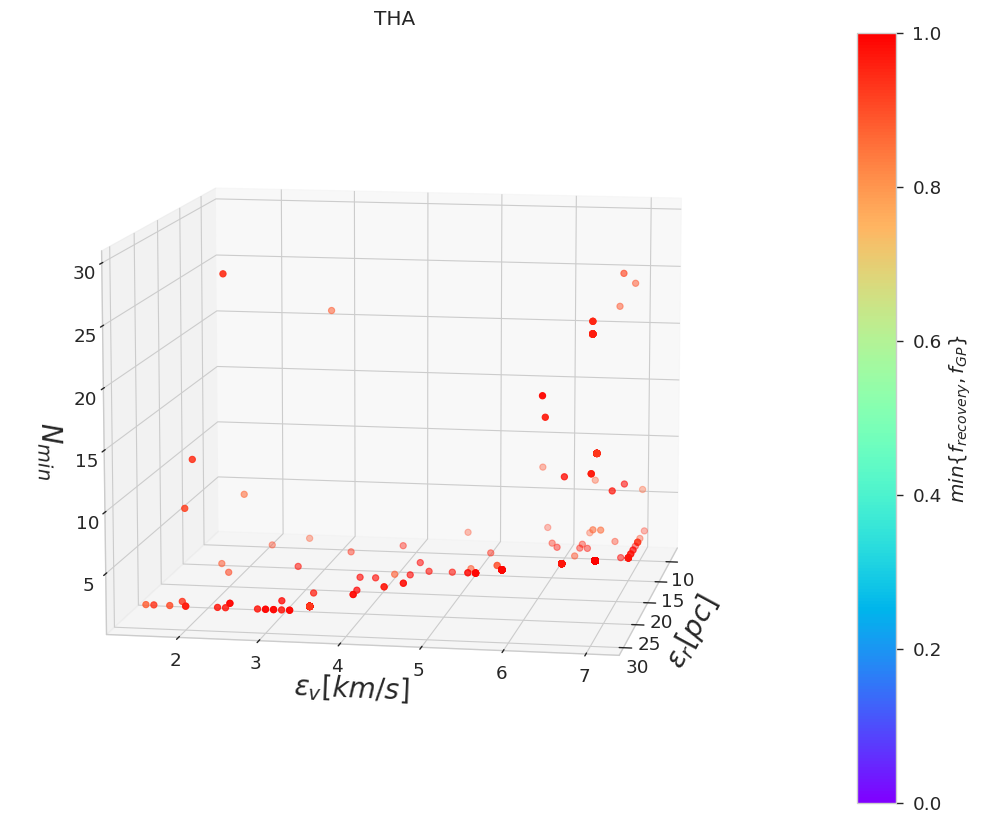

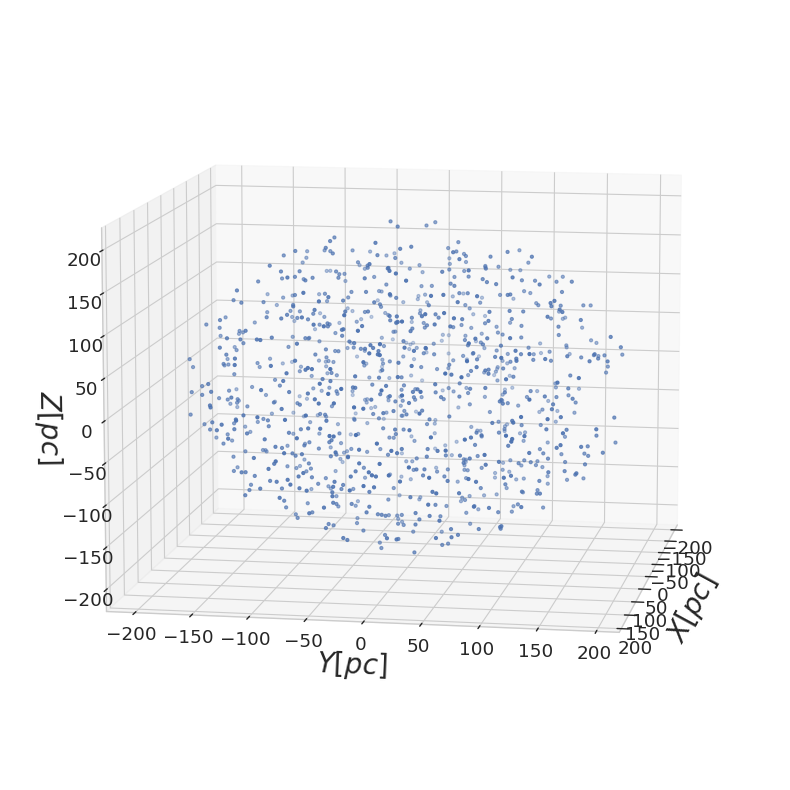

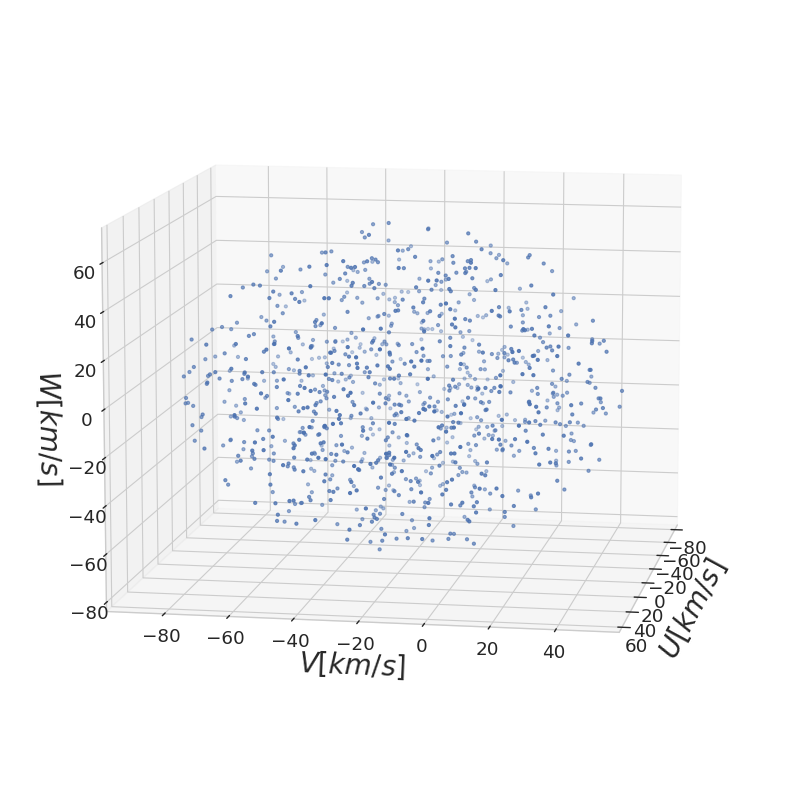

In [8]:
fragmentationLimit      = 10
for i in np.arange(0,finalStatsForNymgs.shape[0],1):
    nymgName            = finalStatsForNymgs.NYMG.iloc[i]
    syntheticResults    = allSyntheticResults[nymgName]
    bestCase            = allBestCases[nymgName]
    syntheticnBestCases = allsyntheticnBestCases[nymgName]
    
    plt.scatter(syntheticResults.groupsPurity,
                syntheticResults.observedRecovery,
                s=10,
                c=syntheticResults.fragmentation,
                vmin=1,
                vmax=4,
                cmap='Set1')
    plt.colorbar(label='fragmentation')
    # plt.scatter(syntheticnBestCases.groupsPurity,
    #             syntheticnBestCases.observedRecovery,
    #             s=100,
    #             marker='+',
    #             color='black')
    plt.xticks(rotation=30)
    plt.xlabel(r'$f_{GP}$')
    plt.ylabel(r'$f_{recovery}$')
    plt.title(nymgName)
    plt.savefig(f"plots_and_images/syntheticRecoveryPurityMaps_{sample}_{nymgName}",bbox_inches='tight')
    plt.show()   
    
    plt.scatter(syntheticResults.nObservedCluster,
                syntheticResults.density,
                s=10,
                c=syntheticResults.min_purity_recovery,
                cmap='rainbow')
    plt.colorbar(label=r'$min\{f_{recovery},f_{GP}\}$')
    # plt.scatter(syntheticnBestCases.nObservedCluster,
    #             syntheticnBestCases.density,
    #             s=100,
    #             marker='+',
    #             color='black')
    plt.axvline(finalStatsForNymgs.observedN.iloc[i],color='black')
    plt.axvline(finalStatsForNymgs.realN.iloc[i],color='black')
    plt.xticks(rotation=30)
    plt.xlabel(r'$\rho_{\sigma_r,\sigma_v}$')
    plt.ylabel(r'$\rho_{\varepsilon,N_{min}}$')
    plt.title(nymgName)
    plt.savefig(f"plots_and_images/syntheticDensityMinMaps_{sample}_{nymgName}",bbox_inches='tight')
    plt.show()
    
    distance = np.sqrt(syntheticResults.XMean**2+syntheticResults.YMean**2+syntheticResults.ZMean**2)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(20)
    cs = ax.scatter(syntheticResults.reps,syntheticResults.veps,syntheticResults.Nmin,s=20,
                    c=syntheticResults.min_purity_recovery,
                    vmin=0,
                    vmax=1,
                    cmap='rainbow')
    plt.colorbar(cs,label=r'$min\{f_{recovery},f_{GP}\}$')
    # ax.scatter(syntheticnBestCases.reps,syntheticnBestCases.veps,syntheticnBestCases.Nmin,s=100,marker='+',color='black')
    ax.set_xlabel(r'$\varepsilon_r[pc]$',fontsize=20)
    ax.set_ylabel(r'$\varepsilon_v[km/s]$',fontsize=20)
    ax.set_zlabel(r'$N_{min}$',fontsize=20)
    ax.tick_params(axis='both', which='major', pad=0)
    ax.view_init(10,10)
    plt.title(nymgName)
    plt.savefig(f"plots_and_images/syntheticBestParameters_{sample}_{nymgName}",bbox_inches='tight')
    plt.show()
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(20)
    ax.scatter(syntheticResults.XMean,syntheticResults.YMean,syntheticResults.ZMean,s=5)
    ax.set_xlabel(r'$X[pc]$',fontsize=20)
    ax.set_ylabel(r'$Y[pc]$',fontsize=20)
    ax.set_zlabel(r'$Z[pc]$',fontsize=20)
    ax.tick_params(axis='both', which='major', pad=0)
    ax.view_init(10,10)
    plt.show()
    
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(20)
    ax.scatter(syntheticResults.UMean,syntheticResults.VMean,syntheticResults.WMean,s=5)
    ax.set_xlabel(r'$U[km/s]$',fontsize=20)
    ax.set_ylabel(r'$V[km/s]$',fontsize=20)
    ax.set_zlabel(r'$W[km/s]$',fontsize=20)
    ax.tick_params(axis='both', which='major', pad=0)
    ax.view_init(10,10)
    plt.show()

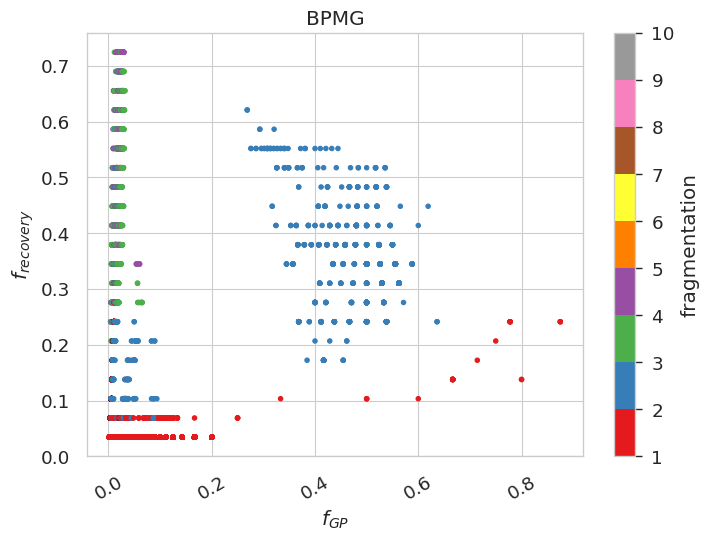

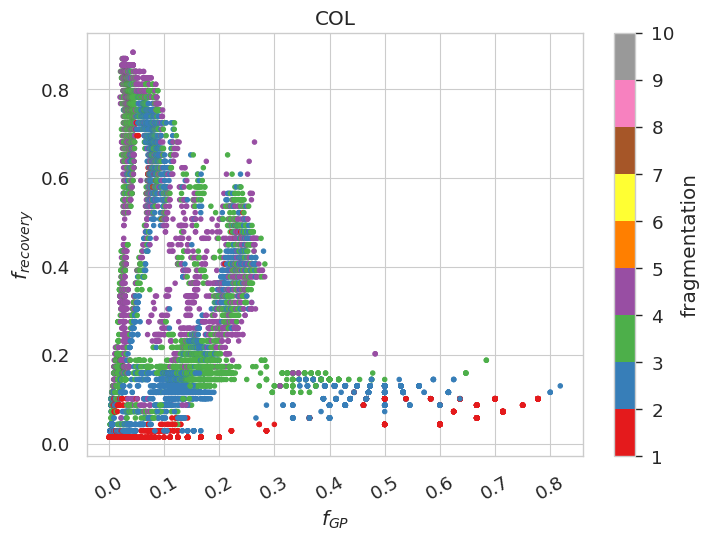

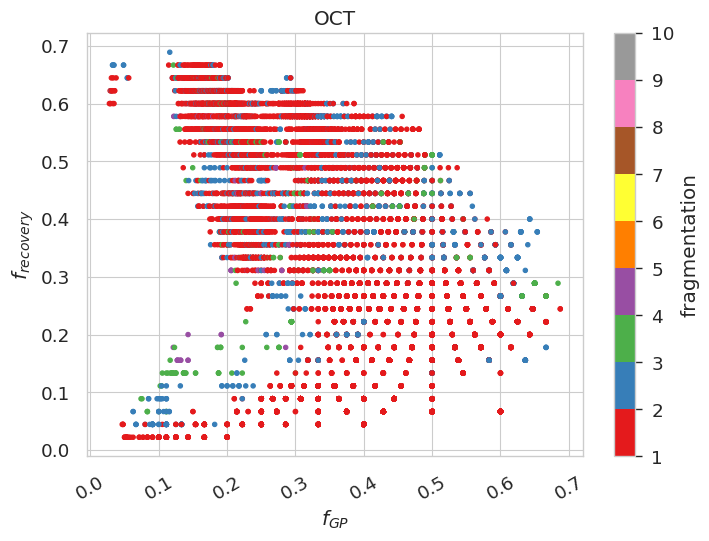

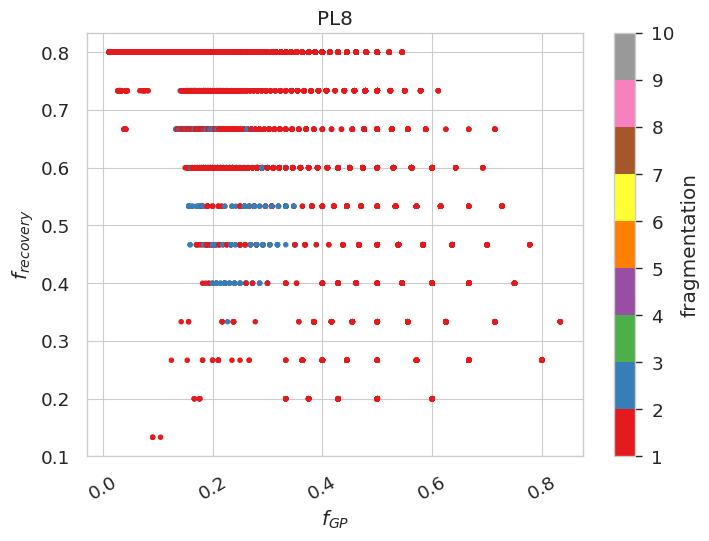

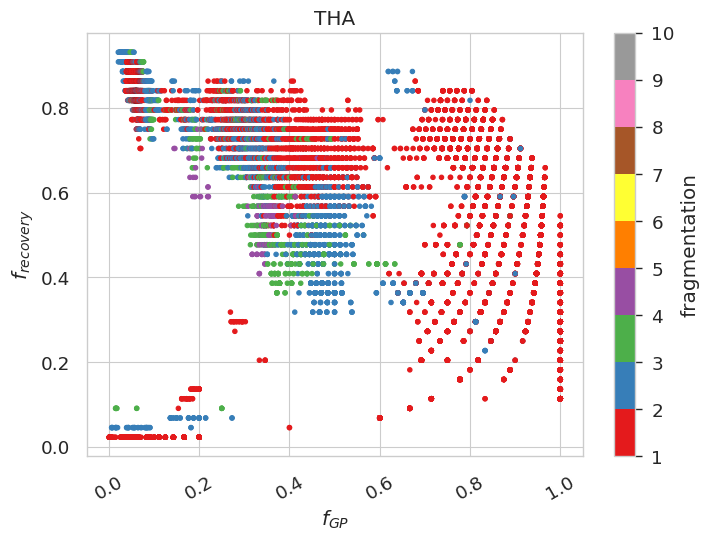

In [9]:
fragmentationLimit = 10

for i in np.arange(0,finalStatsForNymgs.shape[0],1):
    nymgName           = finalStatsForNymgs.NYMG.iloc[i]
    analysisResults    = allAnalysisResults[nymgName]
    nymgDensity        = allNymgDensities[nymgName]
    bestCase           = allBestCases[nymgName]
    
    analysisResults    = analysisResults.sort_values('min_purity_recovery',ascending=True)
    analysisResults    = analysisResults[analysisResults.fragmentation < 5]
    
    plt.scatter(analysisResults.groupsPurity,
                analysisResults.observedRecovery,
                s=10,
                c=analysisResults.fragmentation,
                cmap='Set1',
                vmax=fragmentationLimit,
                label=r'$f_{completness}$')
    plt.colorbar(label='fragmentation')
    # plt.scatter(bestCase.groupsPurity,bestCase.observedRecovery,color='black',marker='+',s=200)
    plt.xticks(rotation=30)
    plt.xlabel(r'$f_{GP}$')
    plt.ylabel(r'$f_{recovery}$')
    plt.title(nymgName)
    plt.savefig(f"plots_and_images/minPurityCompltness_{sample}_{nymgName}",bbox_inches='tight')
    plt.show()
    
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # fig.set_figheight(10)
    # fig.set_figwidth(20)
    # cs = ax.scatter(analysisResults.reps,analysisResults.veps,analysisResults.Nmin,s=20)
    # ax.set_xlabel(r'$\varepsilon_r[pc]$',fontsize=20)
    # ax.set_ylabel(r'$\varepsilon_v[km/s]$',fontsize=20)
    # ax.set_zlabel(r'$N_{min}$',fontsize=20)
    # ax.tick_params(axis='both', which='major', pad=0)
    # ax.view_init(10,10)
    # plt.show()

In [10]:
N                   = int(1e4)
minMass             = 0.002
maxMass             = 10
dMass               = (np.log10(maxMass)-np.log10(minMass))/N    
isochrone           = pd.DataFrame({'mass':10**np.arange(np.log10(minMass),np.log10(maxMass),dMass)}).sort_values(by=['mass'],ascending=False).reset_index(drop=True)
MS       = pd.concat([isochrone['mass'],massPhoto.massToPhoto_baraffe_PARSEC(isochrone,'mass',100000000.0).reset_index(drop=True).astype('float')],axis=1,join='inner')
MS['BR'] = MS.G_BP-MS.G_RP

In [11]:
def histogramBuilder(data,bins,inputColumn,outputColumns):
    hist,centers = np.histogram(data[inputColumn],bins=bins)
    centers = [(centers[i]+centers[i+1])/2 for i in np.arange(0,len(centers)-1,1)]
    return pd.DataFrame({outputColumns[0]:centers,outputColumns[1]:hist})

def histogramWithErrors(data,bins,inputColumns,outputColumns):
    hist = histogramBuilder(data          = log10(data),
                            bins          = bins,
                            inputColumn   = inputColumns[0],
                            outputColumns = outputColumns)
    
    yminusError = np.log10(np.sqrt(hist[outputColumns[1]]))

In [12]:
finalStatsForNymgs

,NYMG,age,realN,observedN,stdX,stdY,stdZ,stdU,stdV,stdW
0,BPMG,24.0,378.0,78.0,40.424574,15.644854,10.916539,6.313158,4.206819,3.437502
1,COL,42.0,262.0,69.0,12.453843,29.382523,18.212931,3.110668,4.683014,3.381467
2,OCT,35.0,163.0,50.0,59.144502,25.393998,7.264142,3.710721,5.089228,4.538781
3,PL8,60.0,32.0,15.0,3.171045,4.772169,1.064719,0.129475,2.054388,0.243825
4,THA,45.0,331.0,44.0,16.705091,12.468963,3.892873,0.972295,0.846301,1.138296


In [13]:
massAgeResults = pd.read_csv('massAgeResults.csv')

In [14]:
def makeImfPlot(data,logMassColumn,NColumn,color,label):
    plt.errorbar(x = data[logMassColumn],
                y = np.log10(data[NColumn]),
                yerr = [np.log10(data[NColumn])-np.log10(data[NColumn]-np.sqrt(data[NColumn])),np.log10(data[NColumn]+np.sqrt(data[NColumn]))-np.log10(data[NColumn])] ,
                color=color)
    plt.scatter(data[logMassColumn],
                np.log10(data[NColumn]),
                label=label,
                color=color,
                s=20)

In [15]:
def powerLaw(a,b,x):
    return a*x+b

def functionParametersFitter(functionsList,xLimitsList,data,xColumn,yColumn):
    nFunctions          = len(functionsList)
    bestParametersList  = []
    bestCovariancesList = []
    
    for i in np.arange(0,nFunctions,1):
        xLimits                         = xLimitsList[i]
        functionToFit                   = functionsList[i]
        dataToFit                       = data[(data[xColumn] > xLimits[0]) &
                                               (data[xColumn] <= xLimits[1])]
        
        bestParameters, bestCovariances = curve_fit(functionToFit,
                                                    dataToFit[xColumn],
                                                    dataToFit[yColumn])
        
        bestParametersList             += [bestParameters]
        bestCovariancesList            += [bestCovariances]
    
    return bestParametersList, bestCovariancesList

In [16]:
imfToFit = pd.DataFrame({'logInferedMass':finalImf.logInferedMass,'logN':np.log10(finalImf.N)})
imfToFit = imfToFit.replace([np.inf, -np.inf], np.nan)

imfToFit = imfToFit.dropna()
massRange0 = np.arange(-2,np.log10(0.3),0.01)
massRange1 = np.arange(np.log10(0.3),1,0.01)
bestParametersList, bestCovariancesList = functionParametersFitter(functionsList = [powerLaw,powerLaw],
                                                                     xLimitsList   = [[massRange0[0],massRange0[len(massRange0)-1]],
                                                                                      [massRange1[0],massRange1[len(massRange1)-1]]],
                                                                     data          = imfToFit,
                                                                     xColumn       = 'logInferedMass',
                                                                     yColumn       = 'logN')


NameError: name 'finalImf' is not defined

In [ ]:
bestCovariancesList

In [ ]:
plt.plot(imfToFit.logInferedMass,imfToFit.logN)

In [ ]:

plt.plot(massRange0,powerLaw(bestParametersList[0][1]-np.sqrt(bestCovariancesList[0][1,1]),
                             bestParametersList[0][0]-np.sqrt(bestCovariancesList[0][0,0]),massRange0))
plt.plot(massRange0,powerLaw(bestParametersList[0][1]+np.sqrt(bestCovariancesList[0][1,1]),
                             bestParametersList[0][0]+np.sqrt(bestCovariancesList[0][0,0]),massRange0))
plt.plot(massRange1,powerLaw(bestParametersList[1][1],bestParametersList[1][0],massRange1))
plt.plot(imfToFit.logInferedMass,imfToFit.logN)

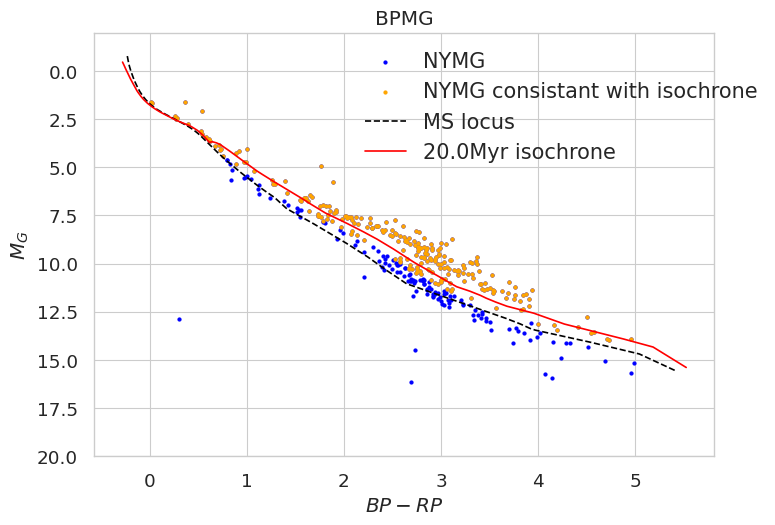

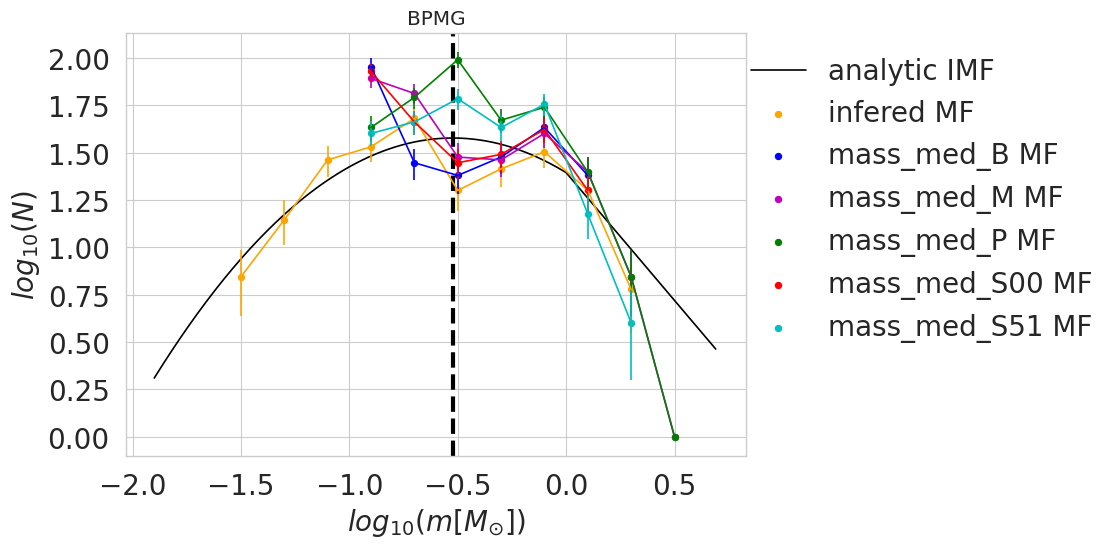

In [18]:
for i in np.arange(0,1,1):
    nymgStats = finalStatsForNymgs.iloc[i]
    nymgName  = nymgStats.NYMG
    age       = isochroneAges[np.abs(isochroneAges.age-finalStatsForNymgs.age.iloc[i]*1e6) ==\
                              np.min(np.abs(isochroneAges.age-finalStatsForNymgs.age.iloc[i]*1e6))].iloc[0][0]
    
    bestCase  = allBestCases[nymgName]
    
    isochrone           = pd.DataFrame({'mass':10**np.arange(np.log10(minMass),np.log10(maxMass),dMass)}).sort_values(by=['mass'],ascending=False).reset_index(drop=True)
    isochrone           = pd.concat([isochrone,massPhoto.massToPhoto_baraffe_PARSEC(isochrone,'mass',age).reset_index(drop=True).astype('float')],
                                    axis=1,
                                    join='inner')
    isochrone['BR']     = isochrone.G_BP-isochrone.G_RP
    
    nymg                = nymgsMatchGdr3[nymgsMatchGdr3.YNMG == nymgName]
    nymgsMatchGdr3      = nymgsMatchGdr3.set_index(nymgsMatchGdr3.source_id)
    nymg                = nymg.set_index(nymg.source_id)
    nymg['BR']          = nymg.phot_bp_mean_mag-nymg.phot_rp_mean_mag
    nymg['MG']          = nymg.phot_g_mean_mag+5-5*np.log10(1000/nymg.parallax)
    

    nymg        = nymg[(nymg.MG >= MGtoMGerr.x.min()) &
                                       (nymg.MG <= MGtoMGerr.x.max()) &
                                       (nymg.MG >= MGtoBRerr.x.min()) &
                                       (nymg.MG <= MGtoBRerr.x.max())]
    
    observedNymg        = massPhoto.isochroneSelector(data           = nymg,
                                                      age            = age,
                                                      deltaMag       =  [1e6,0.5],
                                                      dataMagName    = 'MG',
                                                      dataColorNames = ['phot_bp_mean_mag','phot_rp_mean_mag'])
    
    infMass,allNumericMassPDF,allAnalyticMassPDF = massPhoto.IMFbayesInferer(data        = observedNymg,
                                                                             age         = age,                                                                         
                                                                             photoErrors = [MGtoBRerr,MGtoMGerr],
                                                                             MGcolumn    = 'MG',
                                                                             BRcolumn    = 'BR',
                                                                             nError      = [1,1],
                                                                             idColumn    = 'source_id',
                                                                             nSampling   = int(0))
    
    plt.scatter(nymg.BR,nymg.MG,s=5,color='blue',label='NYMG')
    plt.scatter(observedNymg.BR,observedNymg.MG,s=5,color='orange',label='NYMG consistant with isochrone')
    plt.plot(MS.BR,MS.G,color='black',linestyle='--',label='MS locus')
    plt.plot(isochrone.BR,isochrone.G,color='red',label=f'{age/1e6}Myr isochrone')
    plt.xlabel(r'$BP-RP$')
    plt.ylabel(r'$M_G$')
    plt.title(nymgName)
    plt.ylim(20,-2)
    plt.legend(bbox_to_anchor=(0.0, 0.0, 1.1, 1.),fontsize=15)
    plt.savefig(f'CMD_{nymgName}.png',bbox_inches='tight')
    plt.show()

    logMassBinMin  = -2
    logMassBinMax  = 1
    logMassDBin    = 0.2
    logMassBins    = np.arange(logMassBinMin,logMassBinMax,logMassDBin)

    finalImf = histogramBuilder(data          = np.log10(infMass.drop(['massErrorMinus','massErrorPlus'],axis=1)),
                                bins          = logMassBins,
                                inputColumn   = 'inferedMass',
                                outputColumns = ['logInferedMass','N'])
    massAgeMasses = pd.DataFrame({'mass_med_B':massAgeResults.mass_med_B,
                                  'mass_med_M':massAgeResults.mass_med_M,
                                  'mass_med_P':massAgeResults.mass_med_P,
                                  'mass_med_S00':massAgeResults.mass_med_S00,
                                  'mass_med_S51':massAgeResults.mass_med_S51})
    massAgeMasses = massAgeMasses.replace(-999.9,5)
    
    massAgeImf = pd.DataFrame(np.zeros([massAgeMasses.shape[0],int(2*massAgeMasses.shape[1])]),columns=list(massAgeMasses.columns)+\
                                       ['N'+col for col in list(massAgeMasses.columns)])
    for i in np.arange(0,massAgeMasses.shape[1],1):
        column = massAgeImf.columns[i]
        imf    = histogramBuilder(data          = np.log10(massAgeMasses),
                                     bins          = logMassBins,
                                     inputColumn   = column,
                                     outputColumns = [column,'N'+column])
        massAgeImf[column] = imf[column]
        massAgeImf['N'+column] = imf['N'+column]
        
    
    analytic_imf = np.vectorize(massPhoto.analytic_imf0)
    dm = 0.01
    massRange = np.arange(finalImf.logInferedMass.min(),finalImf.logInferedMass.max(),dm)
    imfNorm = massPhoto.imfNormFinder(data = infMass,
                                      logMassMin = np.log10(infMass.inferedMass.min()),
                                      logMassMax = np.log10(infMass.inferedMass.max()),
                                      dm = dm,
                                      analytic_imf = analytic_imf)
    # imfNorm = finalImf.N.sum()
    
    plt.plot(massRange,np.log10(analytic_imf(0.3,0.57,massRange)*imfNorm*logMassDBin),color='black',label='analytic IMF')
    # plt.plot(massRange,np.log10(powerLaw(popt[0],popt[1],massRange)),color='black')
    makeImfPlot(data=finalImf,
                logMassColumn='logInferedMass',
                NColumn='N',
                color='orange',
                label='infered MF')
    colors = ['b','m','g','r','c']
    for i in np.arange(0,massAgeMasses.shape[1],1):
        column = massAgeImf.columns[i]
        makeImfPlot(data=massAgeImf[10**massAgeImf[column] < 5],
                    logMassColumn=column,
                    NColumn='N'+column,
                    color=colors[i],
                    label=column+' MF')
    plt.axvline(np.log10(0.3),color='black',linestyle='--',linewidth=3)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$log_{10}(m[M_{\odot}])$',fontsize=20)
    plt.ylabel(r'$log_{10}(N)$',fontsize=20)
    plt.legend(bbox_to_anchor=(0.0, 0.0, 1.6, 1.),fontsize=20)
    plt.title(nymgName)
    plt.savefig(f'inferedIMF_{nymgName}.png',bbox_inches='tight')
    plt.show()

In [ ]:
massPDFkeys    = list(allAnalyticMassPDF.keys())


for i in np.arange(0,len(massPDFkeys),1):
    numericMassPDF  = allNumericMassPDF[massPDFkeys[i]]
    numericMassPDF  = numericMassPDF[numericMassPDF.logp.isnull().values == False]
    
    if i%100 == 0:
        plt.scatter(numericMassPDF.mass,np.exp(numericMassPDF.logp))
        plt.xlabel(r'$m[M_{\odot}]$')
        plt.ylabel(r'$ln(p)$')
        plt.axvline(infMass.inferedMass.iloc[i])
        plt.show()

# Best results analysis

In [ ]:
columns             = ['NYMG','nReal','nPhoto','nRecovered','nGroups','fragmentation','recovery','purity','reps','veps','Nmin']
bestCasesStatistics = pd.DataFrame(np.zeros([finalStatsForNymgs.shape[0],len(columns)]),columns = columns)

for i in np.arange(0,finalStatsForNymgs.shape[0],1):   
    AGE                = isochroneNymgAges.age.iloc[i]                                                                                                                                       
    bestCase           = allBestCases[finalStatsForNymgs.NYMG.iloc[i]]
    reps               = bestCase.reps.iloc[0]
    veps               = bestCase.veps.iloc[0]
    Nmin               = bestCase.Nmin.iloc[0]

    MSPMSRVage         = massPhoto.isochroneSelector(data           = MSPMS,
                                                     age            = AGE,
                                                     deltaMag       = [1e6,0.5],
                                                     dataMagName    = 'MG',
                                                     dataColorNames = ['phot_bp_mean_mag','phot_rp_mean_mag'])

    nymg                = nymgsMatchGdr3[nymgsMatchGdr3.YNMG == finalStatsForNymgs.NYMG.iloc[i]]
    
    MSPMSRVage          = MSPMSRVage.set_index(MSPMSRVage.source_id)
    nymg                = nymg.set_index(nymg.source_id)
    
    nymgPhoto           = pd.concat([nymg.YNMG,MSPMSRVage],axis=1,join='inner')
    
    detectedClusters    = pd.read_pickle(f'dataframes_output/Ndmethod/realData_{sample}_{AGE}.pickle')
    bestDetection       = detectedClusters[Nmin][veps][reps]
    bestDetection       = bestDetection.set_index(bestDetection.input_index)
    bestDetectionMatch  = pd.concat([bestDetection.cluster_labels,nymg],axis=1,join='inner')
    
    bestCasesStatistics.NYMG.iloc[i]          = finalStatsForNymgs.NYMG.iloc[i]
    bestCasesStatistics.nReal.iloc[i]         = finalStatsForNymgs.realN.iloc[i]
    bestCasesStatistics.nPhoto.iloc[i]        = nymgPhoto.shape[0]
    bestCasesStatistics.nRecovered.iloc[i]    = bestDetectionMatch.shape[0]
    bestCasesStatistics.nGroups.iloc[i]       = dbat.groupsMatchBuilder(bestDetection,bestDetectionMatch).shape[0]
    bestCasesStatistics.fragmentation.iloc[i] = bestCase.fragmentation.iloc[0]
    bestCasesStatistics.reps.iloc[i]          = reps
    bestCasesStatistics.veps.iloc[i]          = veps
    bestCasesStatistics.Nmin.iloc[i]          = Nmin
    bestCasesStatistics.recovery.iloc[i]      = bestDetectionMatch.shape[0]/nymgPhoto.shape[0]
    bestCasesStatistics.purity.iloc[i]        = bestDetectionMatch.shape[0]/bestCasesStatistics.nGroups.iloc[i]

In [ ]:
bestCasesStatistics